In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
api = '9fe422e6b534a441f6ebf51a7c1c5920ee4ea99f'

In [3]:
stock = 'GOOGL'

In [4]:
data = pdr.get_data_tiingo(stock,api_key = api)

In [5]:
data.reset_index(inplace=True)
#data.set_index('date',inplace=True)
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOGL,2015-10-13 00:00:00+00:00,683.17,688.4600,673.108,674.26,2122338,683.17,688.4600,673.108,674.26,2122338,0.0,1.0
1,GOOGL,2015-10-14 00:00:00+00:00,680.41,690.0400,678.900,683.73,1564582,680.41,690.0400,678.900,683.73,1564582,0.0,1.0
2,GOOGL,2015-10-15 00:00:00+00:00,693.02,694.1600,684.390,685.25,2357829,693.02,694.1600,684.390,685.25,2357829,0.0,1.0
3,GOOGL,2015-10-16 00:00:00+00:00,695.32,696.2200,689.100,695.40,1815759,695.32,696.2200,689.100,695.40,1815759,0.0,1.0
4,GOOGL,2015-10-19 00:00:00+00:00,699.95,700.2397,692.210,694.00,1508585,699.95,700.2397,692.210,694.00,1508585,0.0,1.0


In [6]:
data.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,GOOGL,2020-10-05 00:00:00+00:00,1482.83,1484.7000,1460.09,1462.65,1080058,1482.83,1484.7000,1460.09,1462.65,1080058,0.0,1.0
1254,GOOGL,2020-10-06 00:00:00+00:00,1451.02,1484.5200,1445.01,1475.50,1304752,1451.02,1484.5200,1445.01,1475.50,1304752,0.0,1.0
1255,GOOGL,2020-10-07 00:00:00+00:00,1459.14,1468.9700,1433.23,1459.31,1805448,1459.14,1468.9700,1433.23,1459.31,1805448,0.0,1.0
1256,GOOGL,2020-10-08 00:00:00+00:00,1483.43,1488.0275,1465.45,1465.45,1303802,1483.43,1488.0275,1465.45,1465.45,1303802,0.0,1.0
1257,GOOGL,2020-10-09 00:00:00+00:00,1510.45,1511.8500,1487.00,1492.86,1648340,1510.45,1511.8500,1487.00,1492.86,1648340,0.0,1.0


In [7]:
data['close'].head()

0    683.17
1    680.41
2    693.02
3    695.32
4    699.95
Name: close, dtype: float64

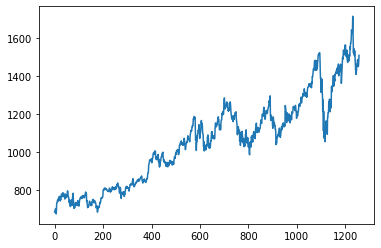

In [8]:
plt.plot(data['close'])

In [9]:
max(data['close'])

1717.39

In [10]:
X = data['close']

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(np.array(X).reshape(-1,1))

In [12]:
X = pd.DataFrame(X)
X = pd.DataFrame(X[0]).set_index(data['date'])

In [13]:
X.head()

,0
date,
2015-10-13 00:00:00+00:00,0.010874
2015-10-14 00:00:00+00:00,0.008235
2015-10-15 00:00:00+00:00,0.020295
2015-10-16 00:00:00+00:00,0.022494
2015-10-19 00:00:00+00:00,0.026923


In [14]:
result = adfuller(X[0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.952692
p-value: 0.770126
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [15]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
fraction = int(len(X)*0.8)
train = X[:fraction]
test = X[fraction:]

In [17]:
time_step = 100
X_train, y_train = create_dataset(train.values, time_step)
X_test, y_test = create_dataset(test.values,time_step)

In [18]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [20]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1],1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 76ms/step - loss: 0.0299 - val_loss: 0.0690
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0165
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0104
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0092
Epoch 5/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0100
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 7/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0103
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0101
Epoch 9/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0092
Epoch 10/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0095

In [23]:
train_predict=lstm_model.predict(X_train)
test_predict=lstm_model.predict(X_test)

In [24]:
train_predict.shape

(905, 1)

In [25]:
test_predict.shape

(151, 1)

In [26]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.01685942808921492

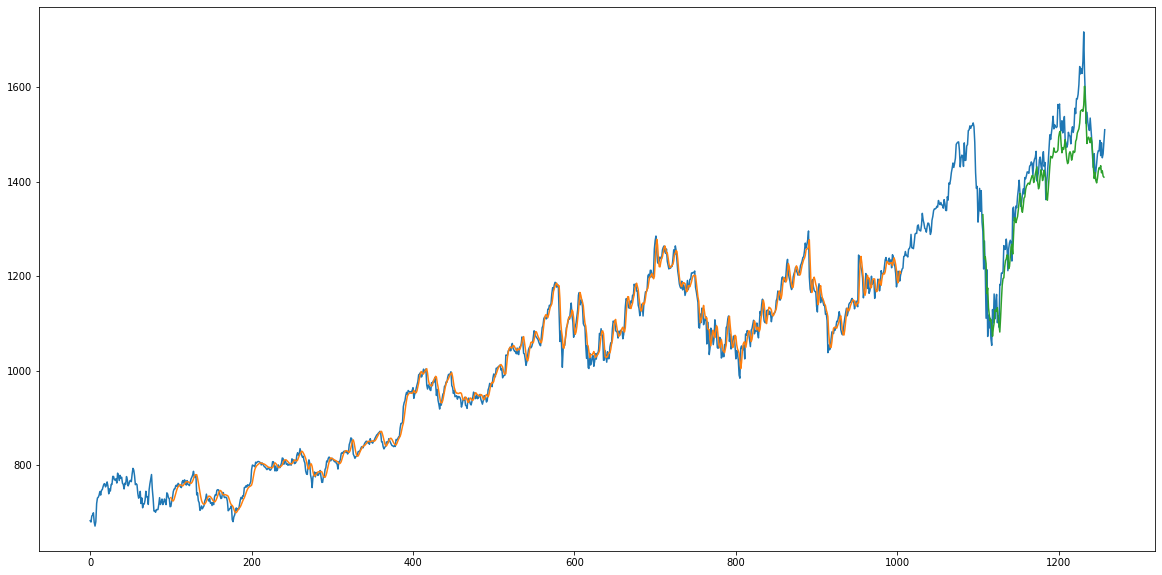

In [27]:
look_back=time_step
df1 = X
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = scaler.inverse_transform(train_predict)
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = scaler.inverse_transform(test_predict)
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Predicting the next 30 days closing values

In [28]:
def future_pred(dataset, time_step,period):
  dataY = []
  for i in range(period):
    a = dataset[-(time_step):]
    a = a.reshape(1,time_step, 1)
    pred = lstm_model.predict(a)
    dataY.append(pred[0])
    dataset = np.append(dataset,pred)
  return np.array(dataY)

In [29]:
future_data = np.array(test_predict[-time_step:]).reshape(-1,1)
new_pred = future_pred(future_data,time_step,30)

In [30]:
vals = []
i = 0
for x in new_pred:
  vals.append([x[0]]) 

In [31]:
closing =scaler.inverse_transform(df1).tolist()
closing = closing + (scaler.inverse_transform(vals).tolist())
close = []
for c in closing:
  close.append(c[0])

In [32]:
import datetime
dates = []
for i in range(30):
  dates.append(datetime.datetime.now() + datetime.timedelta(i))
dates = list(pd.to_datetime(dates))
date_index = list(df1.index)
date_index = date_index + dates

In [33]:
df3 = pd.DataFrame(zip(close,date_index),columns=['closing','date'])
df3 = df3.set_index('date')
df3.head()

,closing
date,
2015-10-13 00:00:00+00:00,683.17
2015-10-14 00:00:00+00:00,680.41
2015-10-15 00:00:00+00:00,693.02
2015-10-16 00:00:00+00:00,695.32
2015-10-19 00:00:00+00:00,699.95


In [34]:
df3.tail()

,closing
date,
2020-11-05 21:44:21.002435,1162.105970
2020-11-06 21:44:21.002437,1156.991825
2020-11-07 21:44:21.002439,1152.011859
2020-11-08 21:44:21.002440,1147.182463
2020-11-09 21:44:21.002442,1142.526541


In [35]:
df1.head()

,0
date,
2015-10-13 00:00:00+00:00,0.010874
2015-10-14 00:00:00+00:00,0.008235
2015-10-15 00:00:00+00:00,0.020295
2015-10-16 00:00:00+00:00,0.022494
2015-10-19 00:00:00+00:00,0.026923


In [36]:
old = df3.iloc[:1258]

In [37]:
old.head()

,closing
date,
2015-10-13 00:00:00+00:00,683.17
2015-10-14 00:00:00+00:00,680.41
2015-10-15 00:00:00+00:00,693.02
2015-10-16 00:00:00+00:00,695.32
2015-10-19 00:00:00+00:00,699.95


In [38]:
old.tail()

,closing
date,
2020-10-05 00:00:00+00:00,1482.83
2020-10-06 00:00:00+00:00,1451.02
2020-10-07 00:00:00+00:00,1459.14
2020-10-08 00:00:00+00:00,1483.43
2020-10-09 00:00:00+00:00,1510.45


In [39]:
new = df3.iloc[1258:]

In [40]:
new.head()

,closing
date,
2020-10-11 21:44:21.002382,1374.897217
2020-10-12 21:44:21.002390,1355.665327
2020-10-13 21:44:21.002393,1335.703584
2020-10-14 21:44:21.002395,1319.194169
2020-10-15 21:44:21.002397,1306.576266


In [41]:
new.tail()

,closing
date,
2020-11-05 21:44:21.002435,1162.105970
2020-11-06 21:44:21.002437,1156.991825
2020-11-07 21:44:21.002439,1152.011859
2020-11-08 21:44:21.002440,1147.182463
2020-11-09 21:44:21.002442,1142.526541


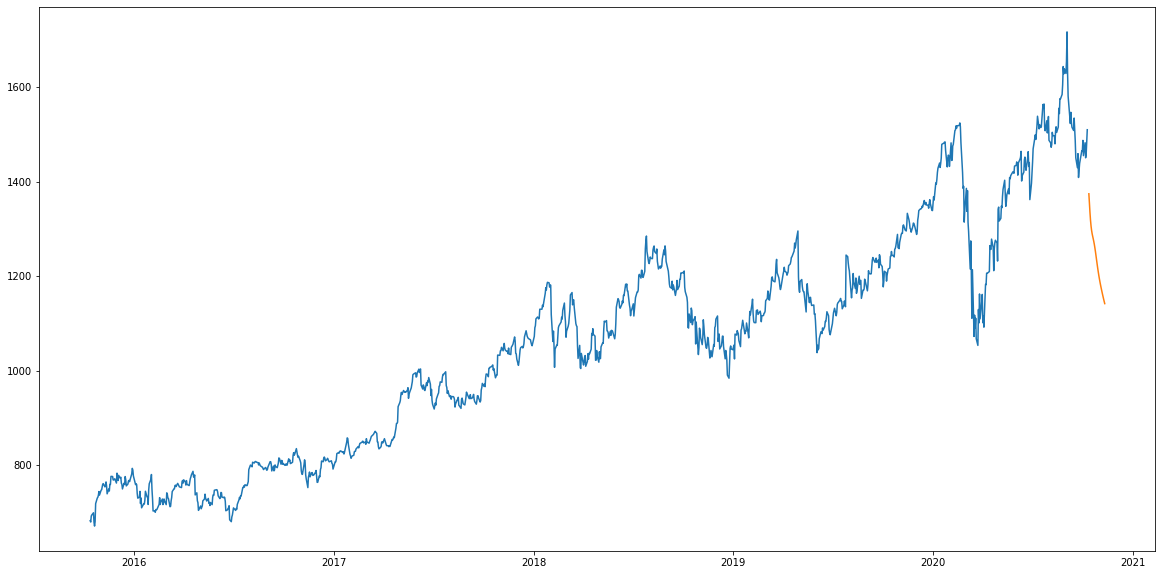

In [42]:
plt.figure(figsize=(20,10))
plt.plot(old['closing'])
plt.plot(new['closing'])
#plt.plot(testPredictPlot)
plt.show()

In [43]:
df3.head()

,closing
date,
2015-10-13 00:00:00+00:00,683.17
2015-10-14 00:00:00+00:00,680.41
2015-10-15 00:00:00+00:00,693.02
2015-10-16 00:00:00+00:00,695.32
2015-10-19 00:00:00+00:00,699.95


In [44]:
df3.reset_index(inplace = True)

In [45]:
df3['date'] = list(df3['date'])

In [46]:
df3.head()

,date,closing
0,2015-10-13 00:00:00+00:00,683.17
1,2015-10-14 00:00:00+00:00,680.41
2,2015-10-15 00:00:00+00:00,693.02
3,2015-10-16 00:00:00+00:00,695.32
4,2015-10-19 00:00:00+00:00,699.95


In [47]:
df3.iloc[-29]

date       2020-10-12 21:44:21.002390
closing                       1355.67
Name: 1259, dtype: object